INTRODUCTION

This notebook will aim to provide an explanation and application of different feature ranking methods, namely that of Recursive Feature Elimination (RFE), Stability Selection, linear models as well as Random Forest. But first off, it is always imperative to give credit where credit is due. 

The contents of this notebook are as follows:

Data Cleaning and Visualisation : This section will revolve around exploring the data and visualising some summary statistics.

Stability Selection via Randomised Lasso Method : Introduce a relatively new feature selection method called "Stability Selection" and using the Randomised Lasso in its implementation

Recursive Feature Elimination : Implementing the Recursive Feature Elimination method of feature ranking via the use of basic Linear Regression

Linear Model Feature Coefficients : Implementing Linear Regression and using the inbuilt estimated coefficients for our feature selection

Random Forest Feature Selection : Using the Random Forest's convenient attribute "feature_importances" to calculate and ultimately rank the feature importance.

In [29]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.feature_selection import RFE, f_regression
from sklearn.linear_model import (LinearRegression,Ridge, Lasso)
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix, mean_absolute_error, accuracy_score

In [30]:
df = pd.read_csv('kc_house_data 3.csv')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [31]:
df.isnull().any()

id               False
date             False
price            False
bedrooms         False
bathrooms        False
sqft_living      False
sqft_lot         False
floors           False
waterfront       False
view             False
condition        False
grade            False
sqft_above       False
sqft_basement    False
yr_built         False
yr_renovated     False
zipcode          False
lat              False
long             False
sqft_living15    False
sqft_lot15       False
dtype: bool

In [32]:
df = df.drop(['id', 'date'], axis=1)

**Create pairplot to see how features are distributed**

/Users/jamiezeng/anaconda2/lib/python3.6/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/jamiezeng/anaconda2/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/jamiezeng/anaconda2/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/jamiezeng/anaconda2/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


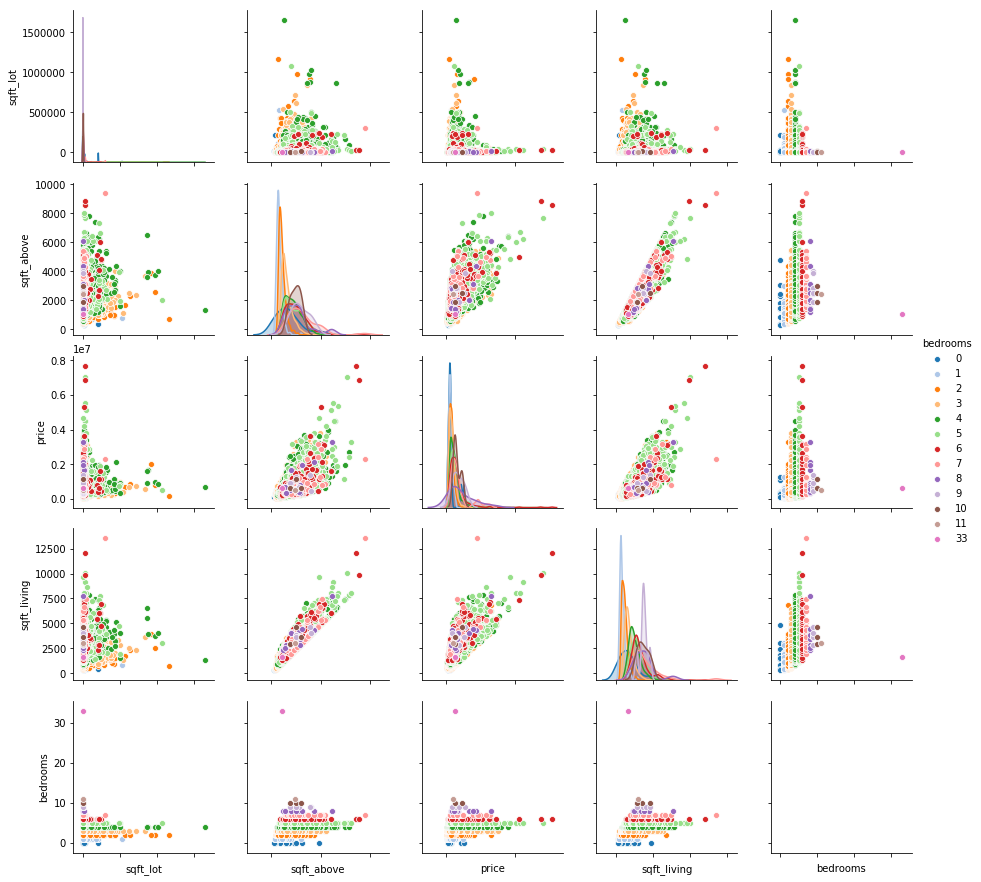

In [33]:
sns.pairplot(df[['sqft_lot','sqft_above','price','sqft_living','bedrooms']], 
             hue='bedrooms', palette='tab20').set(xticklabels=[])

Text(0.5,1,'Correlation of features')

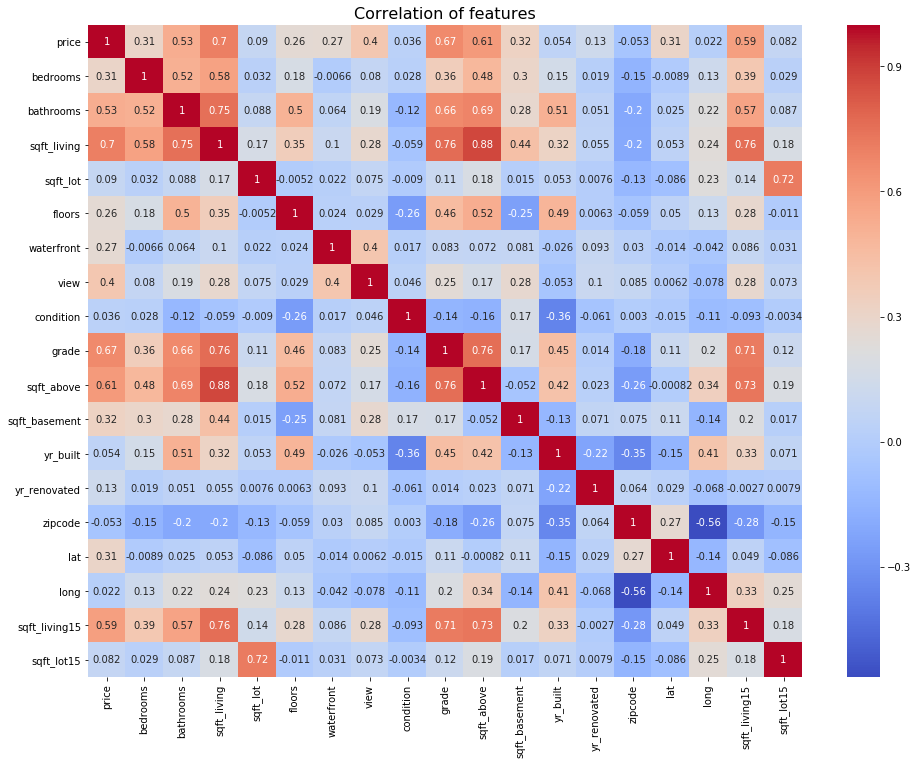

In [34]:
plt.figure(figsize=(16,12))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation of features', fontsize=16)

In [35]:
from sklearn.model_selection import train_test_split


X=df.drop(columns=['price'])
print(X.columns)

y=df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=1)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.3, 
                                                    random_state=2)

Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [36]:
model = RandomForestRegressor()
model.fit(X_train, y_train)
pre = model.predict(X_test)

/Users/jamiezeng/anaconda2/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [37]:
mean_absolute_error(y_test, pre)

78903.22609500309

**Feature importance with Catboost.**


In [38]:
from catboost import Pool, CatBoostRegressor, cv

**Create CatBoostRegressor model with Mean squared error loss function.**

In [39]:
def perform_model(X_train, y_train,X_valid, y_valid,X_test, y_test):
    model = CatBoostRegressor(
        random_seed = 400,
        loss_function = 'RMSE',
        iterations=400,
    )
    
    model.fit(
        X_train, y_train,
        eval_set=(X_valid, y_valid),
        verbose=False
    )
    
    print("RMSE on training data: "+ model.score(X_train, y_train).astype(str))
    print("RMSE on test data: "+ model.score(X_test, y_test).astype(str))
    
    return model


**Run model and check score.**

In [40]:
model=perform_model(X_train, y_train,X_valid, y_valid,X_test, y_test)

RMSE on training data: 100371.38781087365
RMSE on test data: 147938.01550895313


**Create feature importance plot.**

In [41]:
feature_score = pd.DataFrame(list(zip(X.dtypes.index, model.get_feature_importance(Pool(X, label=y)))),
                columns=['Feature','Score'])

feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')

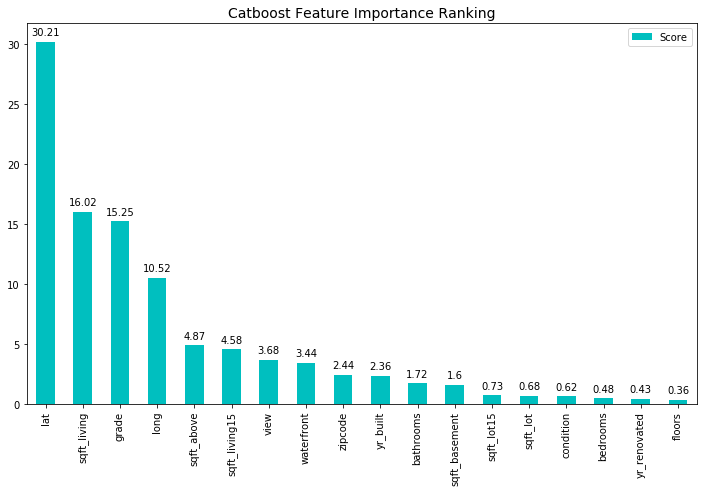

In [42]:
plt.rcParams["figure.figsize"] = (12,7)
ax = feature_score.plot('Feature', 'Score', kind='bar', color='c')
ax.set_title("Catboost Feature Importance Ranking", fontsize = 14)
ax.set_xlabel('')

rects = ax.patches

labels = feature_score['Score'].round(2)

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 0.35, label, ha='center', va='bottom')

plt.show()

**Drop 10 columns which give least information.**

In [45]:
X=df.drop(['floors', 'yr_renovated', 'bedrooms', 'condition', 'sqft_lot', 'sqft_lot15', 'sqft_basement', 'bathrooms', 'yr_built',
          'zipcode'], axis=1)

print(X.columns)
y=df['price']

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X, y, test_size=0.3, 
                                                    random_state=1)

X_train_2, X_valid_2, y_train_2, y_valid_2 = train_test_split(X_train, y_train, test_size=0.3, 
                                                    random_state=2)

Index(['price', 'sqft_living', 'waterfront', 'view', 'grade', 'sqft_above',
       'lat', 'long', 'sqft_living15'],
      dtype='object')


In [46]:
model=perform_model(X_train_2, y_train_2,X_valid_2, y_valid_2,X_test_2, y_test_2)

RMSE on training data: 15098.81982576942
RMSE on test data: 78385.44155427902


In [47]:
model = RandomForestRegressor()
model.fit(X_train_2, y_train_2)
pre = model.predict(X_test_2)

/Users/jamiezeng/anaconda2/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [48]:
mean_absolute_error(y_test_2, pre)

1883.0579272054283

**As we can see our model perform a lot better after using Catboost for feature selection**